# Step 1: Setting up the environment

#### To create and activate a virtual environment, run on your terminal:

**Windows:**


```
python -m venv venv
```
```
venv\Scripts\Activate
```

**macOS/Linux:**

```
python3 -m venv venv
```

```
source venv/bin/activate
```

#### After the environment is activated, install the requirements:

```
pip install -r requirements.txt
```


# Step 2: Pre-processing the document

#### What you will need:
1. PDF Document (skin cancer detection paper in my case)
2. Embedding model (I am using Sentence-Bert)

As described in the Readme file, the aim of this tutorial is to build a RAG-assisted LLM that can retrieve information from research papers, helping students and researchers get a quicker understanding of the paper. This example will refer to a pdf titled *Real and simulated multispectral imaging of a palimpsest*. This paper is not yet publicly available since I am currently in the process of publishing, but feel free to use any paper you would like to retrieve information from. The same steps will apply to any paper / book. All you need to do is download it in pdf format and add your file path to the variable 'path'.

To pre-process the PDF document, we will use an embedding model. 

#### ⚠️ Now, what does “embedding” mean in AI?

In this tutorial, we are trying to get our AI model to understand a paper (complex text data). The problem is, our model can only understand numbers. That is where embeddings come in.

> An embedding is a way of representing complex data (like words or images) as a list of numbers — called a vector — in such a way that the relationships between items are preserved.


#### Let’s dive into that:

Think of each item (a word, an image, a sentence) as a point in space - a location on a map. The closer two points are, the more related their meanings are.

For example:

- The word “cat” will be close to “dog”.

- The word “car” will be far away from “banana”.

That’s because in real life, cats and dogs are similar (both animals, pets), while a car and a banana are not.

So embeddings help us map meaning into a mathematical space.

#### 🧐 What is an embedding model?

An embedding model is an AI model that has learned how to take something complex — like a sentence — and turn it into a vector (a list of numbers) that captures its meaning.

Different embedding models specialize in different kinds of data. The table below shows some examples of open-source embedding models for different use cases:


| Data Type      | Embedding model examples               | What do they capture?                            |
|----------------|----------------------------------------|--------------------------------------------------|
| Words          | Word2Vec, GloVe, FastText              | Word meanings, analogies, syntactic similarity   |
| Sentences/Text | Sentence-BERT (SBERT), Instructor, E5  | Semantic similarity between sentences/documents  |
| Images         | DINO, OpenCLIP                         | Visual concepts, cross-modal (image-text) meaning|
| Audio          | Wav2Vec 2.0, Whisper                   | Speech content, audio features                   |
| Code           | CodeBERT, GraphCodeBERT                | Code syntax and semantics                        |
  

In this tutorial we are looking to read PDF documents, therefore, we need a model that embeds data based on semantic similarity. I have chosen Sentence-BERT, but it is interchangable for any sentence / text embedding model. Once you have build your own RAG-assisted LLM, you can experiment with different models and decide what works best for you

Note that embedding models do not exactly embed words or sentences, they embed tokens.

#### ❓ What is a token?

A token is a smallest unit of input that a language model (like GPT or BERT) understands.

In most modern NLP systems, tokens are not exactly words — they can be:

- A whole word (hello)

- A subword (un, believ, able)

- A punctuation mark (!, .)

- Even just a few characters (Th, is)

Think of a token as a "chunk" of text — a building block the model processes one at a time.

> **Example**
> 
> Sentence: "This is amazing!" might be tokenized as:
> 
> ['This', ' is', ' amazing', '!']


.
> Note that, on average in English text, 1 token is equal to 4 characters.


#### Now that we know how the data pre_processing will work, let's get started. 








## 2.1. Importing the relevant modules, getting the PDF we want to read, and extracting text:

In [1]:
# Import relevant modules
import fitz
import os
import requests
import re
from tqdm.auto import tqdm

# Get PDF path (change this variable to your pdf path)
#____________________________________________________________________
path = r"G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf"
#____________________________________________________________________

# Check that the path exists
if os.path.exists(path):
    print(f"PDF file '{path}' exists.")
else:
    print(f"PDF file '{path}' does not exist")

# Open the PDF file
paper = fitz.open(path)
    
# Define a helper function to extract text from the pdf
def extract_text(paper: fitz.Document):
  """Applies formatting to the PDF textand stores the content in a list of dictionaries
  Inputs: 
      paper (fitz.Document): PDF document
  Outputs: 
      output (list[dict]): List of dictionaries containing the formatted extracted text from each PDF page 
      and the corresponding page number
  """

  # Define an empty list that will be filled with the extracted text
  output = []

  for page_number, page in enumerate(paper):
    paper_text = page.get_text()
    paper_text = re.sub(r'\s+', ' ', paper_text).strip() # removes any \n or white spaces
    output.append({"page_number": page_number,       
                   "text": paper_text
                   })
  return output

# Check that the helper function works as expected by printing the first sentence
output = extract_text(paper=paper)
display = output[0]["text"][:75]
print(" ")
print(f"'{display}...'")

PDF file 'G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf' exists.
 
'For submission to Heritage Science Real and simulated multispectral imaging...'


## 2.2. Segmenting the extracted text

First of all, we will use the Natural Language Processing (NLP) library **SpaCy** to divide our extracted text in sentences.

This is due to the fact that embedding models cannot process an infinite number of tokens, therefore we need to limit the number of tokens by chunking the text into groups of sentences.

For this tutorial I have split the text in chunks of 8 sentences, although this number is arbitrary. Feel free to experiment and decide what works best with your model. What is the criteria to keep in mind:
1. Smaller groups of text will be easier to inspect, making it easier to filter content
2. The text segments need to fit into our embedding model's context window
3. Segments too large will make the context that will be passed to the LLM too vague
4. Segments too short might leave out information that is also relevant / be misleading
5. We want to find a segment / chunk size so that the context passed to the LLM will be specific and focused



In [2]:
# Import the English language model from spaCy
from spacy.lang.en import English

# Initialize the language processor
nlp_engine = English()

# Add sentence segmentation capability
# This NLP engine (SpaCy) breaks text into individual sentences
nlp_engine.add_pipe("sentencizer")

# Define how many sentences should be in each text segment
sentences_per_segment = 8

# Verify that sentence segmentation works correctly
sample_text = nlp_engine("SpaCy. is an NLP. library. that splits. text. into sentences. Let's. test. it.")
assert len(list(sample_text.sents)) == 9
print(f"This cell tests that the NLP engine (SpaCy) is detecting sentences as expected, \
and that the split_into_segments function splits the text in groups of \
{sentences_per_segment} sentences. \n")
print(list(sample_text.sents))

# Function to divide sentences into manageable segments
def split_into_segments(sentence_collection: list[str], 
                   segment_length: int = sentences_per_segment):
    """
    Divides a collection of sentences into segments of specified length
    
    Args:
        sentence_collection: List of sentences to divide
        segment_length: Maximum number of sentences per segment
        
    Returns:
        List of sentence segments
    """
    segments = []
    for i in range(0, len(sentence_collection), segment_length):
        segments.append(sentence_collection[i:i + segment_length])
    return segments

# Test segmentation function
test_sentences = [sent.text for sent in sample_text.sents]
split_into_segments(test_sentences)

This cell tests that the NLP engine (SpaCy) is detecting sentences as expected, and that the split_into_segments function splits the text in groups of 8 sentences. 

[SpaCy., is an NLP., library., that splits., text., into sentences., Let's., test., it.]


[['SpaCy.',
  'is an NLP.',
  'library.',
  'that splits.',
  'text.',
  'into sentences.',
  "Let's.",
  'test.'],
 ['it.']]

In [3]:
# Process each page in the PDF document
for item in tqdm(output):
    # Identify sentences in the document text
    pdf_processed = nlp_engine(item["text"])
    
    # Store sentences as strings
    item["sentences"] = [str(sent) for sent in pdf_processed.sents]
    
    # Create sentence segments and count them
    item["sentence_segments"] = split_into_segments(
        sentence_collection=item["sentences"],
        segment_length=sentences_per_segment
    )
    
    # Record metadata
    item["segment_count"] = len(item["sentence_segments"])
    item["sentence_count"] = len(item["sentences"])

  0%|          | 0/14 [00:00<?, ?it/s]

Once the document has been divided in groups of sentences (segments or chunks), we will display a sample of one page in the PDF, to ensure this task was performed correctly. Additionally, we will print statistics on the average number of sentences and sentence segments per page.

In [4]:
import random

# Print a random sample from the output
print("\nRandom Sample (shortened for display):")
sample_item = random.sample(output, k=1)[0]  # Get one random item

# Create a copy of the sample to modify for display
display_sample = sample_item.copy()

# Truncate the text to first 10 characters
if "text" in display_sample:
    display_sample["text"] = display_sample["text"][:10] + "..." if len(display_sample["text"]) > 10 else display_sample["text"]

# Truncate each sentence to first 10 characters
if "sentences" in display_sample:
    display_sample["sentences"] = [s[:10] + "..." if len(s) > 10 else s for s in display_sample["sentences"]]

# Truncate each sentence segment to first 10 characters
if "sentence_segments" in display_sample:
    # For each segment in the list of segments
    display_sample["sentence_segments"] = [
        # For each sentence in the segment
        [s[:10] + "..." if len(s) > 10 else s for s in segment]
        for segment in display_sample["sentence_segments"]]

# Print the modified sample
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(display_sample)


Random Sample (shortened for display):
{ 'page_number': 5,
  'segment_count': 1,
  'sentence_count': 3,
  'sentence_segments': [['Figure 2: ...', 'a) is the ...', 'b)-(e) are...']],
  'sentences': ['Figure 2: ...', 'a) is the ...', 'b)-(e) are...'],
  'text': 'Figure 2: ...'}


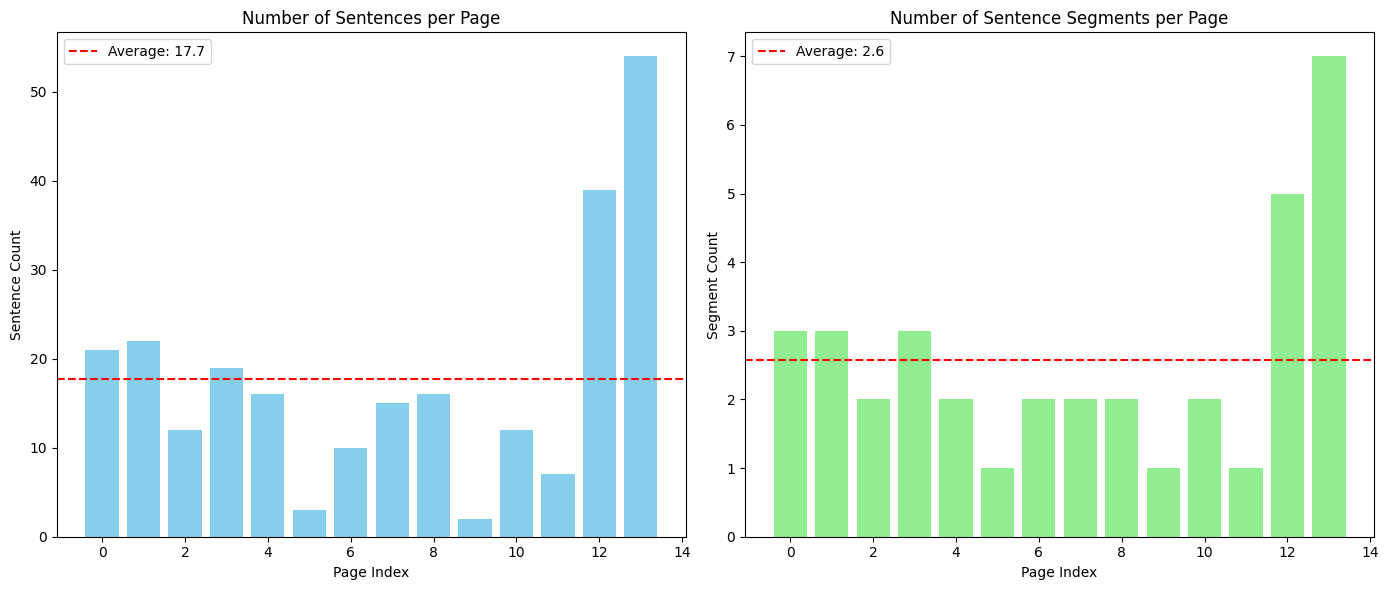

Document statistics:
Total pages: 14
Total sentences: 248
Average sentences per page: 17.7
Average segments per page: 2.6
 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the data for plotting
sentence_counts = [item["sentence_count"] for item in output]
segment_counts = [item["segment_count"] for item in output]

# Calculate averages
avg_sentence_count = np.mean(sentence_counts)
avg_segment_count = np.mean(segment_counts)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First chart: Sentences per page
ax1.bar(range(len(sentence_counts)), sentence_counts, color='skyblue')
ax1.axhline(y=avg_sentence_count, color='red', linestyle='--', 
            label=f'Average: {avg_sentence_count:.1f}')
ax1.set_title('Number of Sentences per Page')
ax1.set_xlabel('Page Index')
ax1.set_ylabel('Sentence Count')
ax1.legend()

# Second chart: Sentence segments per page
ax2.bar(range(len(segment_counts)), segment_counts, color='lightgreen')
ax2.axhline(y=avg_segment_count, color='red', linestyle='--', 
            label=f'Average: {avg_segment_count:.1f}')
ax2.set_title('Number of Sentence Segments per Page')
ax2.set_xlabel('Page Index')
ax2.set_ylabel('Segment Count')
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.savefig('document_analysis.png', dpi=300)
plt.show()

# Print summary statistics
print(f"Document statistics:")
print(f"Total pages: {len(output)}")
print(f"Total sentences: {sum(sentence_counts)}")
print(f"Average sentences per page: {avg_sentence_count:.1f}")
print(f"Average segments per page: {avg_segment_count:.1f}")
print(" ")




The final step in section _'2.2. Segmenting the extracted text'_ is to join all sentences within 1 segmented, converting the segment back into a paragraph. Each joined paragraph will be treated as a document entry.

In [6]:
# Define text formatting function
def format_text(text):
    """Apply consistent formatting to scientific text for improved readability."""
    # Fix spacing after common punctuation marks
    for punct in ['.', ',', ';', ':', '?', '!']:
        text = re.sub(f'\\{punct}([^\\s])', f'{punct} \\1', text)
    
    # Remove duplicate spaces
    text = re.sub(r' {2,}', ' ', text)

    # Apply strip() function and remove '\n'
    text = text.replace("\n", " ").strip()
    
    # Standardize citation formatting (e.g., "[1]text" → "[1] text")
    text = re.sub(r'(\[\d+\])([A-Za-z])', r'\1 \2', text)
    
    return text
    
# Convert each segment into its own document entry
final_segments = []
for item in tqdm(output):
  for segment in item["sentence_segments"]:
    # Create a new dictionary for this segment
    segment_entry = {}
    
    # Preserve the source page information
    segment_entry["page_number"] = item["page_number"]
    
    # Combine sentences into a single coherent paragraph
    combined_text = "".join(segment)

    # Clean formatting using helper function
    cleaned_text = format_text(combined_text)
    
    # Store the processed text
    segment_entry["content"] = cleaned_text
    
    # Calculate approximate token count (rough estimation)
    segment_entry["estimated_tokens"] = len(cleaned_text) / 4
    
    # Add to our collection
    final_segments.append(segment_entry)

# Display total number of segments created
print(f"Total segments created: {len(final_segments)}")

  0%|          | 0/14 [00:00<?, ?it/s]

Total segments created: 36


In [7]:
import random
print(f"The variable 'final_segments' has a length of: {len(final_segments)}")

display_segment = random. randint(0, len(final_segments))
display = final_segments[display_segment]["content"][:30]
print(" ")
print(f"'{display}...'")

The variable 'final_segments' has a length of: 36
 
'Multispectral imaging (MSI) us...'




## 2.3. Embedding each segment
The next step is to **embed** each segment of sentences into its own **numerical representation**.

For this tutorial, I use the [`all-MiniLM-L6-v2`](https://www.sbert.net/docs/pretrained_models.html) model from the `sentence-transformers` library. This lightweight model offers a strong balance between speed and performance. Trained on a diverse mix of Natural Language Inference (NLI) and paraphrase datasets, it is particularly effective for general-purpose **semantic similarity** tasks and is well-suited for applications with resource constraints. In my own experiments with the paper at hand, it showed the best balance between computational cost and accurate results.

However, the **optimal embedding model may vary** depending on the domain of your content. For example, if you're working with complex scientific papers, you may want to experiment with [`specter2_base`](https://huggingface.co/allenai/specter2_base), developed by **Allen AI**. **SPECTER2** is trained specifically on citation networks and scientific corpora, making it highly effective for embedding scholarly documents in a way that captures **citation-based semantic relationships**. It is particularly useful for literature recommendation and clustering.

Another robust alternative is [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2), also from `sentence-transformers`. It is considered one of the **highest-performing models** for general sentence embeddings across various benchmarks like **Semantic Textual Similarity (STS)** and clustering tasks. It provides better performance than `MiniLM` in many contexts but comes with a **higher computational cost**.

In short, while `all-MiniLM-L6-v2` is a great starting point for many use cases, I encourage you to **test different models** depending on the specificity of your domain and performance needs. Embedding model choice can significantly affect downstream task accuracy, especially in specialized fields such as **law**, **medicine**, or **scientific research**.


In [9]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from time import perf_counter
from tqdm import tqdm

def embed_segments(final_segments):
    """
    Generate embeddings for all sentence segments using MiniLM model.
    
    Args:
        final_segments: List of dictionaries containing sentence segments
        
    Returns:
        Updated list with embeddings added to each dictionary
    """
    # Load model - MiniLM is faster and lighter than MPNet
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Process batches to improve efficiency
    # We can use a larger batch size with the smaller model
    batch_size = 32
    
    for i in tqdm(range(0, len(final_segments), batch_size), desc="Generating embeddings"):
        # Get the current batch
        batch = final_segments[i:i+batch_size]
        
        # Extract texts from the batch
        texts = []
        for item in batch:
            if "sentence_segments" in item and isinstance(item["sentence_segments"], list) and len(item["sentence_segments"]) > 0:
                # Join the first segment of sentences
                texts.append(" ".join(item["sentence_segments"][0]))
            elif "sentences" in item and isinstance(item["sentences"], list):
                # Join all sentences
                texts.append(" ".join(item["sentences"]))
            elif "content" in item:
                # Use content directly if it exists
                if isinstance(item["content"], list):
                    texts.append(" ".join(item["content"]))
                else:
                    texts.append(item["content"])
            else:
                # Fallback to empty string if no recognizable content
                texts.append("")
        
        # Generate embeddings directly (simpler than with Transformers)
        # The encode method handles tokenization, model inference, and extraction
        embeddings = model.encode(texts, convert_to_tensor=True)
        
        # Convert to numpy and store
        embeddings_np = embeddings.cpu().numpy()
        
        # Assign embeddings to the items in the batch
        for j, item in enumerate(batch):
            final_segments[i+j]["embedding"] = embeddings_np[j]
    
    return final_segments

# Step 3: Similarity Search

Once we have embedded the text segments, we can move on to performing **semantic similarity search**. This allows us to retrieve the most relevant information from the paper based on a user query — a key step in building a **Retrieval-Augmented Generation (RAG)** system.

#### What we're doing:
We want to search for a query (e.g. *"How many times is UCL equipment mentioned in the paper?"*) and retrieve the most relevant segments of text. These segments can then be passed to an LLM to generate an accurate and grounded response.

#### Steps involved:
1. **Define the query string**  
2. **Convert the query string into an embedding**, using the same model used to embed the text segments
3. **Compute similarity** between the query embedding and each text chunk embedding using a similarity function like the **dot product** or **cosine similarity** function
4. **Sort the results** by similarity score in descending order to identify the most relevant segments  

> **Note:**  
> When using dot product, make sure that:
> - The query and document embeddings have the same vector shape
> - Both are converted to the same data type (e.g., float32 tensors)

This similarity step is crucial in ensuring the LLM receives contextually relevant information, improving the accuracy of the final response.


In [28]:
def search_similar_segments(final_segments, query_text, top_k=5):
    """
    Search for segments similar to a query using cosine similarity.
    
    Args:
        final_segments: List of dictionaries containing text segments and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar segments
    """
    # Load model (same as used for embedding segments)
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    start_time = perf_counter()
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # 2. Convert all segment embeddings to a tensor for batch processing
    all_embeddings = np.array([segment["embedding"] for segment in final_segments])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute cosine similarity
    # SentenceTransformer models already normalize outputs, but let's ensure
    # Normalize embeddings if needed
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    query_embedding = query_embedding / query_embedding.norm()
    
    # Compute similarity scores (dot product of normalized vectors = cosine similarity)
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(similarity_scores, min(top_k, len(final_segments)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual segments for the top results
    top_results = [final_segments[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        
        # Display page number if available
        if "page_number" in result:
            print(f"   Page: {result['page_number']}")
        
        # Display text content based on available keys
        if "sentence_segments" in result and isinstance(result["sentence_segments"], list) and len(result["sentence_segments"]) > 0:
            segment_text = " ".join(result["sentence_segments"][0])
            print(f"   Text: {segment_text[:150]}...")
        elif "sentences" in result and isinstance(result["sentences"], list):
            sentences_text = " ".join(result["sentences"])
            print(f"   Text: {sentences_text[:150]}...")
        elif "content" in result:
            if isinstance(result["content"], list):
                content_text = " ".join(result["content"])
            else:
                content_text = result["content"]
            print(f"   Text: {content_text[:150]}...")
        else:
            print("   Text: [No text content available]")
            
        print()
    
    return top_k_indices, top_k_scores, top_results


# Enhanced version with statistical analysis
def analyse_similarity_distribution(final_segments, query_text):
    """
    Analyze the distribution of similarity scores for a query.
    
    Args:
        final_segments: List of dictionaries containing text segments and their embeddings
        query_text: The query text to search for
        
    Returns:
        Tuple of (scores, threshold)
    """
    # Load model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Analyzing similarity distribution for query: {query_text}")
    
    # Embed the query
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # Get all embeddings
    all_embeddings = np.array([segment["embedding"] for segment in final_segments])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # Ensure normalized vectors
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    query_embedding = query_embedding / query_embedding.norm()
    
    # Compute similarity scores
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0].cpu().numpy()
    
    # Analyze distribution
    mean_score = np.mean(similarity_scores)
    std_score = np.std(similarity_scores)
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    
    # Calculate a reasonable threshold (mean + 1.5*std is often useful)
    threshold = mean_score + 1.5 * std_score
    
    print(f"Score Statistics:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std Dev: {std_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")
    print(f"  Suggested Threshold: {threshold:.4f}")
    print(f"  Documents above threshold: {np.sum(similarity_scores > threshold)}/{len(similarity_scores)}")
    
    return similarity_scores, threshold, mean_score


# Example usage
if __name__ == "__main__":
    # Embed the segments
    final_embedded_segments = embed_segments(final_segments)
    print(f"Generated embeddings for {len(final_segments)} segments")
    
    # Optional: Check the embedding dimension
    if final_segments:
        print(f"Embedding dimension: {final_embedded_segments[0]['embedding'].shape}")
    
    # First analyze distribution
    query = "How many times is UCL equipment for multispectral imaging mentioned in the paper"
    scores, threshold, mean_score = analyse_similarity_distribution(final_embedded_segments, query)
    
    # Then search with that threshold
    indices, scores, results = search_similar_segments(final_embedded_segments, query)

NameError: name 'embed_segments' is not defined

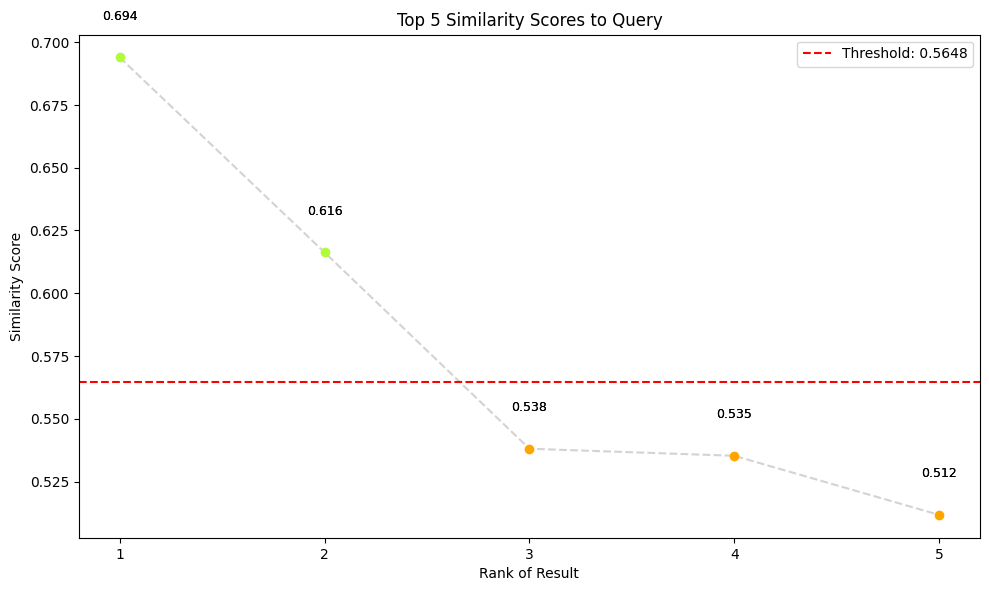

In [35]:
# Print top scores distribution

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line chart
#ax.plot(range(1, len(scores) + 1), scores, marker='o', color='royalblue', label='Similarity Score')

# Plot threshold line
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')

# Plot line segments between points
ax.plot(range(1, len(scores) + 1), scores, color='lightgray', linestyle='--', zorder=1)

# Plot each point with conditional color
for i, score in enumerate(scores):
    color = '#B0FC38' if score >= threshold else '#FFA500'
    ax.plot(i + 1, score, marker='o', color=color, zorder=2)
    ax.text(i + 1, score + 0.015, f'{score:.3f}', ha='center', fontsize=9)

# Annotate each point with its score
for i, score in enumerate(scores):
    ax.text(i + 1, score + 0.015, f'{score:.3f}', ha='center', fontsize=9)

# Set chart title and labels
ax.set_title('Top 5 Similarity Scores to Query')
ax.set_xlabel('Rank of Result')
ax.set_ylabel('Similarity Score')
ax.set_xticks(range(1, len(scores) + 1))

# Add legend
ax.legend()

# Display chart
plt.tight_layout()
plt.savefig('top_similarity_scores.png', dpi=300)
plt.show()


In [16]:
print(scores)
import matplotlib.pyplot as plt
import numpy as np

# Sample similarity scores for the top 5 chunks (replace with your actual data)
top_scores = [0.6939, 0.6123, 0.4521, 0.3894, 0.3228]
threshold = 0.5648

# Calculate average similarity among top results
avg_top_score = np.mean(top_scores)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line chart
ax.plot(range(1, len(top_scores) + 1), top_scores, marker='o', color='royalblue', label='Similarity Score')

# Plot threshold line
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')

# Annotate each point with its score
for i, score in enumerate(top_scores):
    ax.text(i + 1, score + 0.015, f'{score:.3f}', ha='center', fontsize=9)

# Set chart title and labels
ax.set_title('Top 5 Similarity Scores to Query')
ax.set_xlabel('Rank of Result')
ax.set_ylabel('Similarity Score')
ax.set_xticks(range(1, len(top_scores) + 1))

# Add legend
ax.legend()

# Display chart
plt.tight_layout()
plt.savefig('top_similarity_scores.png', dpi=300)
plt.show()

# Summary
print("Top 5 similarity scores:")
for i, score in enumerate(top_scores, 1):
    print(f"Rank {i}: {score:.4f}")
print(f"Average similarity (top 5): {avg_top_score:.4f}")


[0.69385856 0.6162428  0.538053   0.53525066 0.51172376]


# Step 4: Import an LLM and provide additional context (RAG pipeline)

In this step, we integrate a **Large Language Model (LLM)** to complete our Retrieval-Augmented Generation (RAG) pipeline. For this, we will looad an **open-source LLM** such as one of the [LLaMA models](https://huggingface.co/models?search=llama), although you are free to choose any compatible model. We will provide **additional context** by incorporating the results from our similarity search through a carefully engineered prompt.

### What we will be doing:
- We **select the top 5 most relevant text segments** from the similarity search above.
- Only the segments with a **similarity score above 0.7** will be considered
- These selected segments are then **inserted into a prompt** engineered for the LLM, alongside the user query

This context-aware prompt ensures the LLM generates a response grounded in the source material, improving both **accuracy** and **reliability**.

We will import the **transformers** library to load our open-source model.

In [15]:
# TEST_________________________________________________________________________________----
#___________________________________________________________________________________________-
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
# Log in - HuggingFace
from huggingface_hub import login
login()

def generate_prompt_with_context(query, top_k_results, top_k_scores, threshold):
    """
    Builds a prompt for the LLM by including relevant text segments above a similarity threshold.

    Args:
        query (str): User's question.
        top_k_results (list): List of top-k segment dictionaries.
        top_k_scores (list): Corresponding similarity scores.
        threshold (float): Minimum score required to include a segment.
        
    Returns:
        str: Final prompt string for the LLM.
    """
    # Filter results based on the threshold
    selected_segments = []
    for segment, score in zip(top_k_results, top_k_scores):
        if score >= threshold:
            # Extract text from the most appropriate field
            if "content" in segment:
                text = " ".join(segment["content"]) if isinstance(segment["content"], list) else segment["content"]
            elif "sentences" in segment:
                text = " ".join(segment["sentences"])
            elif "sentence_segments" in segment and len(segment["sentence_segments"]) > 0:
                text = " ".join(segment["sentence_segments"][0])
            else:
                continue  # Skip if no valid content
            selected_segments.append(text.strip())

    # Combine into a single context block
    context_text = "\n\n".join(selected_segments[:5])  # Limit to top 5 chunks

    # Create final prompt
    prompt = f"""You are an AI assistant helping analyze a scientific paper.

Answer the following question based on the relevant context extracted from the paper.

### Context:
{context_text}

### Question:
{query}

### Answer:"""

    return prompt


# Example usage
prompt = generate_prompt_with_context(
    query="How many times is UCL equipment for multispectral imaging mentioned in the paper?",
    top_k_results=results,
    top_k_scores=scores,
    threshold
)

# Load open-source LLM (example: TinyLLaMA or another compact model)
#model_name = "meta-llama/Llama-2-7b-chat-hf"  # Replace with your preferred model
model_name = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
llm_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)

# Generate response
response = llm_pipeline(prompt, max_new_tokens=300, do_sample=False)[0]["generated_text"]
print(response)


ConnectTimeout: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/google/gemma-2b/tree/main/additional_chat_templates?recursive=False&expand=False (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000140CF73DAD0>, 'Connection to huggingface.co timed out. (connect timeout=None)'))"), '(Request ID: 96807c22-fe06-444d-81fd-3267f659d11a)')